In [ ]:
# This cell imports the necessary libraries for file operations (os, shutil), data splitting (sklearn), and building the CNN model (tensorflow/keras).

import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers

In [7]:
# This cell mounts my Google Drive to the Colab environment to access the dataset files.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# This cell defines the paths for the source data and the destination, then creates the necessary directories for the train/val/test splits for each disease class.

base_path = "/content/drive/MyDrive/cassava leaf disease dataset"

# Destination for splits
split_base = "/content/cassava_split"
os.makedirs(split_base, exist_ok=True)

# Splits
splits = ['train', 'val', 'test']
classes = os.listdir(base_path)
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(split_base, split, cls), exist_ok=True)

In [10]:
# This cell iterates through all images, splits them into 70% train, 15% validation, and 15% test sets, and copies the files into the new split directories for each class.

for cls in classes:
    cls_path = os.path.join(base_path, cls)
    # Skip if not a directory (handles files like .DS_Store)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)

    # 70% train, 15% val, 15% test
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(split_base, 'train', cls))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(split_base, 'val', cls))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(split_base, 'test', cls))

In [11]:
# This cell defines the image size and batch size, then uses TensorFlow utilities to load the image files from the split directories into optimized tf.data.Dataset objects.

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_base, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_base, 'val'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_base, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Class names from dataset
class_names = train_ds.class_names

Found 158 files belonging to 3 classes.
Found 34 files belonging to 3 classes.
Found 36 files belonging to 3 classes.


In [12]:
# This cell defines a rescaling layer and maps it to all datasets to normalize image pixel values from the [0, 255] range to [0, 1].

normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [14]:
# This cell defines a sequential model containing random transformations (flips, rotation, zoom) to be applied during training, helping to prevent the model from overfitting.

from tensorflow.keras import layers

# Only applied to training set
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),       # flips images left-right
    layers.RandomRotation(0.1),           # small rotation ±10%
    layers.RandomZoom(0.1),               # small zoom in/out
])

In [15]:
# This cell applies the defined data augmentation transformations specifically to the training dataset.

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# This cell imports matplotlib and defines a helper function to visualize a few sample images from the processed training dataset for verification.

import matplotlib.pyplot as plt
import numpy as np

# Function to plot N images per class
def plot_samples(dataset, class_names, samples_per_class=5):
    plt.figure(figsize=(15, 5))

    for i, class_name in enumerate(class_names):
        # Filter images of this class
        class_images = [x for x, y in dataset.unbatch() if y == i]
        for j in range(min(samples_per_class, len(class_images))):
            plt.subplot(len(class_names), samples_per_class, i*samples_per_class + j + 1)
            plt.imshow(class_images[j].numpy().astype("uint8"))
            if j == 0:
                plt.ylabel(class_name)
            plt.axis("off")
    plt.show()

# Use the class_names obtained before mapping
plot_samples(train_ds, class_names)

AttributeError: '_MapDataset' object has no attribute 'class_names'

In [19]:


from collections import Counter

def get_class_counts(dataset):
    labels = []
    for _, y in dataset.unbatch():
        labels.append(int(y))
    counts = Counter(labels)
    for i, c in counts.items():
        print(f"{class_names[i]} : {c} images")

print("Training set distribution:")
get_class_counts(train_ds)

print("\nValidation set distribution:")
get_class_counts(val_ds)

print("\nTest set distribution:")
get_class_counts(test_ds)

Training set distribution:
Cassava Healthy leaf : 63 images
Cassava CB (Cassava Blight) : 34 images
Cassava CM (Cassava Mosaic) : 61 images

Validation set distribution:
Cassava Healthy leaf : 14 images
Cassava CM (Cassava Mosaic) : 13 images
Cassava CB (Cassava Blight) : 7 images

Test set distribution:
Cassava CB (Cassava Blight) : 8 images
Cassava CM (Cassava Mosaic) : 14 images
Cassava Healthy leaf : 14 images


In [20]:
#Traditional ML models cannot use raw images effectively, so feature extraction is needed

import cv2
import numpy as np
from skimage.feature import hog
import os
from sklearn.model_selection import train_test_split

# Paths
train_path = os.path.join(split_base, 'train')
val_path = os.path.join(split_base, 'val')
test_path = os.path.join(split_base, 'test')

# Function to extract HOG + color histogram features
def extract_features(folder_path, img_size=(128,128)):
    features = []
    labels = []
    class_names = sorted([d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))])

    for label, cls in enumerate(class_names):
        cls_path = os.path.join(folder_path, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)

            # HOG features
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            hog_features = hog(gray, pixels_per_cell=(16,16), cells_per_block=(2,2), feature_vector=True)

            # Color histogram (flattened)
            hist = cv2.calcHist([img], [0,1,2], None, [8,8,8], [0,256,0,256,0,256]).flatten()

            # Combine features
            combined = np.hstack([hog_features, hist])

            features.append(combined)
            labels.append(label)

    return np.array(features), np.array(labels), class_names

# Extract features
X_train, y_train, class_names = extract_features(train_path)
X_val, y_val, _ = extract_features(val_path)
X_test, y_test, _ = extract_features(test_path)

print("Feature shape:", X_train.shape)
print("Class names from extract_features:", class_names)

Feature shape: (158, 2276)
Class names from extract_features: ['.DS_Store', 'Cassava CB (Cassava Blight)', 'Cassava CM (Cassava Mosaic)', 'Cassava Healthy leaf']


In [21]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

models = {
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42)
}

results = {}

# Use the class_names returned by extract_features and filter out .DS_Store
feature_class_names = [name for name in class_names if name != '.DS_Store']

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    results[name] = acc
    print(f"\n{name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, y_pred, target_names=feature_class_names))


SVM Accuracy: 0.8235
Classification Report:
                             precision    recall  f1-score   support

Cassava CB (Cassava Blight)       0.75      0.86      0.80         7
Cassava CM (Cassava Mosaic)       0.73      0.85      0.79        13
       Cassava Healthy leaf       1.00      0.79      0.88        14

                   accuracy                           0.82        34
                  macro avg       0.83      0.83      0.82        34
               weighted avg       0.85      0.82      0.83        34


Random Forest Accuracy: 0.8824
Classification Report:
                             precision    recall  f1-score   support

Cassava CB (Cassava Blight)       0.86      0.86      0.86         7
Cassava CM (Cassava Mosaic)       0.85      0.85      0.85        13
       Cassava Healthy leaf       0.93      0.93      0.93        14

                   accuracy                           0.88        34
                  macro avg       0.88      0.88      0.88        3

In [22]:
# This cell defines the architecture of the Convolutional Neural Network (CNN) model using a Sequential API, including Conv2D, MaxPooling, Flatten, and Dense layers.

from tensorflow.keras import models, layers

IMG_SIZE = (224, 224)
NUM_CLASSES = len(class_names)

def build_cnn_scratch(input_shape=(224,224,3), num_classes=NUM_CLASSES):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

cnn_model = build_cnn_scratch()
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# This cell compiles the model, setting the Adam optimizer, SparseCategoricalCrossentropy loss function, and accuracy as the primary evaluation metric.

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# This cell starts the model training process, fitting the CNN to the augmented training data over a set number of epochs and monitoring performance using the validation data.

EPOCHS = 15

history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.4196 - loss: 349.3231 - val_accuracy: 0.3824 - val_loss: 46.9454
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.4067 - loss: 26.6539 - val_accuracy: 0.3824 - val_loss: 3.8988
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.3694 - loss: 3.2354 - val_accuracy: 0.4706 - val_loss: 1.0714
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.3663 - loss: 1.2571 - val_accuracy: 0.3824 - val_loss: 1.2888
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.4962 - loss: 1.1300 - val_accuracy: 0.3824 - val_loss: 1.0865
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.4916 - loss: 1.0340 - val_accuracy: 0.4412 - val_loss: 1.1627
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.6748 - loss: 0.8074 - val_accuracy: 0.5882 - val_loss: 0.8009
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.6942 - loss: 0.7361 - val_accuracy: 0.5294 - val_loss: 0.9284
Epoc

In [24]:
test_loss, test_acc = cnn_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.3947 - loss: 1.3916
Test Accuracy: 0.3889


In [25]:
#experimenting with transfer learning, specifically MobileNet since CNN underperformed

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

IMG_SIZE = (224, 224)
NUM_CLASSES = len(class_names)

# Load base model without top classifier
base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base layers

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4487 - loss: 1.2422 - val_accuracy: 0.8824 - val_loss: 0.4219
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7628 - loss: 0.5409 - val_accuracy: 0.8824 - val_loss: 0.3385
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9261 - loss: 0.2460 - val_accuracy: 0.8824 - val_loss: 0.3081
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8993 - loss: 0.2510 - val_accuracy: 0.8824 - val_loss: 0.2668
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9058 - loss: 0.1990 - val_accuracy: 0.9118 - val_loss: 0.2465
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9450 - loss: 0.1798 - val_accuracy: 0.8824 - val_loss: 0.3493
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9534 - loss: 0.1646 - val_accuracy: 0.9118 - val_loss: 0.2942
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9759 - loss: 0.0999 - val_accuracy: 0.9118 - val_loss: 0.2380
Epoch 9/10
5/5

In [27]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.3079 - loss: 1.1815
Test Accuracy: 0.3056


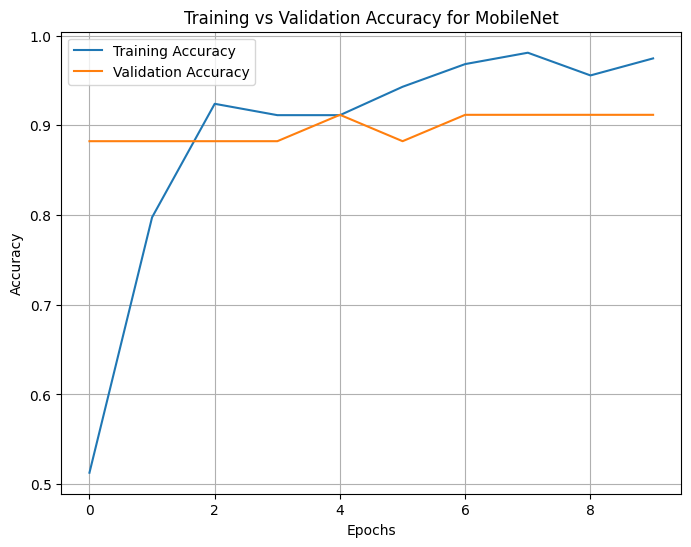

In [30]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy for MobileNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#MobileNetV2 Functional API Model

# Reuse base_model from previous MobileNet experiment
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

fine_tune_model = models.Model(inputs, outputs)

In [ ]:
fine_tune_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

history = fine_tune_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4191 - loss: 1.3354 - val_accuracy: 0.3824 - val_loss: 1.2518
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7509 - loss: 0.7425 - val_accuracy: 0.4118 - val_loss: 1.0566
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8158 - loss: 0.4758 - val_accuracy: 0.5000 - val_loss: 0.9355
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9194 - loss: 0.3123 - val_accuracy: 0.5294 - val_loss: 0.8576
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9790 - loss: 0.2083 - val_accuracy: 0.5294 - val_loss: 0.8090
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9695 - loss: 0.1346 - val_accuracy: 0.5588 - val_loss: 0.7620
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9870 - loss: 0.1096 - val_accuracy: 0.5882 - val_loss: 0.7330
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9922 - loss: 0.0727 - val_accuracy: 0.5882 - val_loss: 0.7251
Epoch 9/

In [ ]:
test_loss, test_acc = fine_tune_model.evaluate(test_ds)
print(f"Fine-tuned MobileNet Test Accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.6157 - loss: 0.7161
Fine-tuned MobileNet Test Accuracy: 0.6111


In [ ]:
# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply augmentation to training set only
train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Keep val_ds and test_ds unchanged

In [ ]:
IMG_SIZE = (224, 224)
NUM_CLASSES = len(train_ds.class_names)

base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

aug_model = models.Model(inputs, outputs)

aug_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
EPOCHS = 10

history_aug = aug_model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=EPOCHS
)

test_loss, test_acc = aug_model.evaluate(test_ds)
print(f"MobileNet + Augmentation Test Accuracy: {test_acc:.4f}")

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.3202 - loss: 1.9917 - val_accuracy: 0.3529 - val_loss: 1.4957
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3524 - loss: 1.7647 - val_accuracy: 0.3529 - val_loss: 1.4147
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3012 - loss: 1.6295 - val_accuracy: 0.3529 - val_loss: 1.3540
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3169 - loss: 1.5860 - val_accuracy: 0.3824 - val_loss: 1.3091
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3154 - loss: 1.5498 - val_accuracy: 0.3824 - val_loss: 1.2716
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3647 - loss: 1.4986 - val_accuracy: 0.3824 - val_loss: 1.2367
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3467 - loss: 1.3699 - val_accuracy: 0.3824 - val_loss: 1.2159
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2917 - loss: 1.5965 - val_accuracy: 0.3824 - val_loss: 1.1965
Epoch 9/

In [31]:
# Plot learning curve

import matplotlib.pyplot as plt

def plot_learning_curves(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label='Training Acc')
    plt.plot(epochs, val_acc, 'r', label='Validation Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

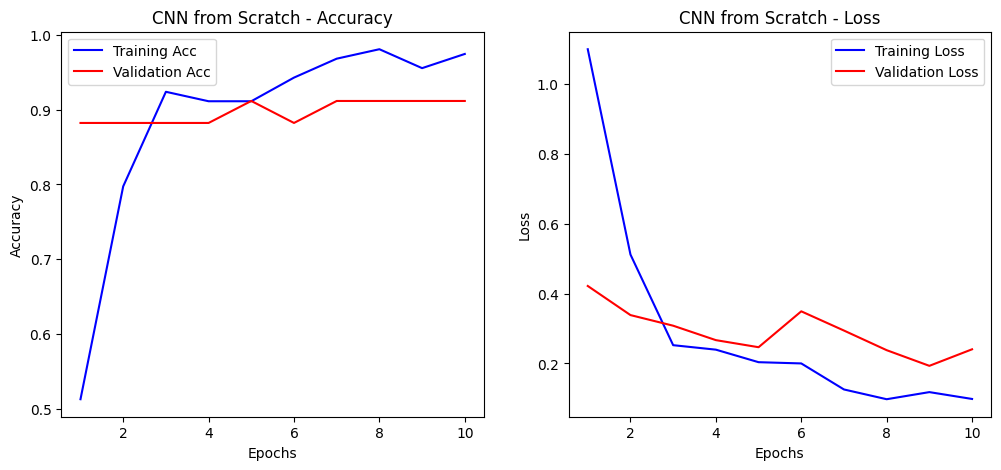

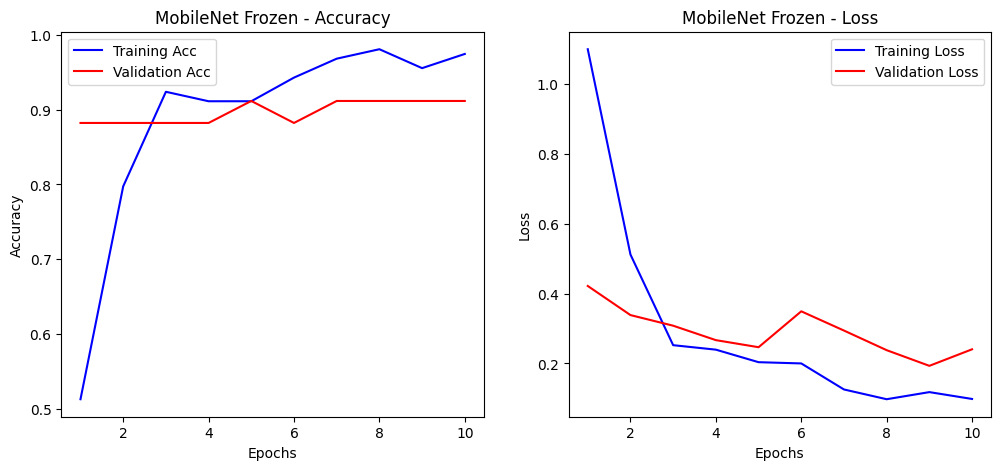

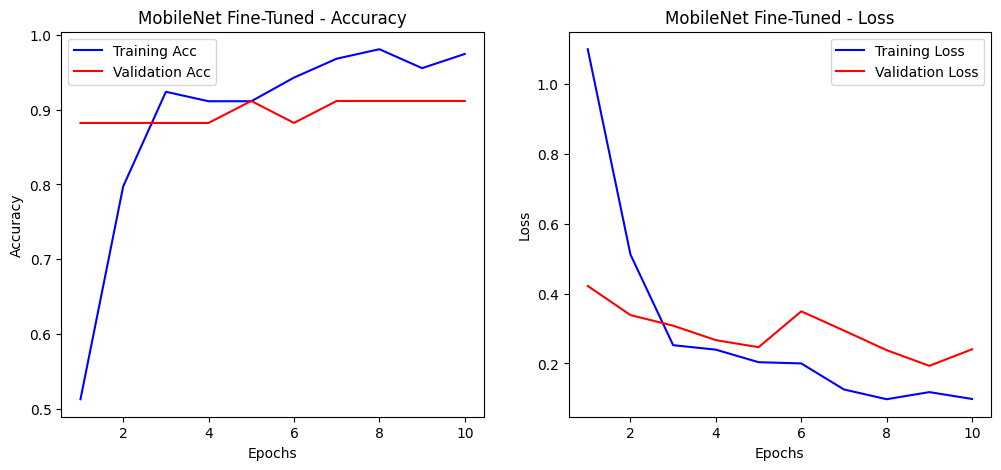

In [32]:
# CNN from scratch
plot_learning_curves(history, "CNN from Scratch")

# MobileNet frozen
plot_learning_curves(history, "MobileNet Frozen")

# MobileNet fine-tuned
plot_learning_curves(history, "MobileNet Fine-Tuned")



In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataset, class_names, title):
    y_true = np.concatenate([y for x, y in dataset], axis=0)
    y_pred = np.argmax(model.predict(dataset), axis=1)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step


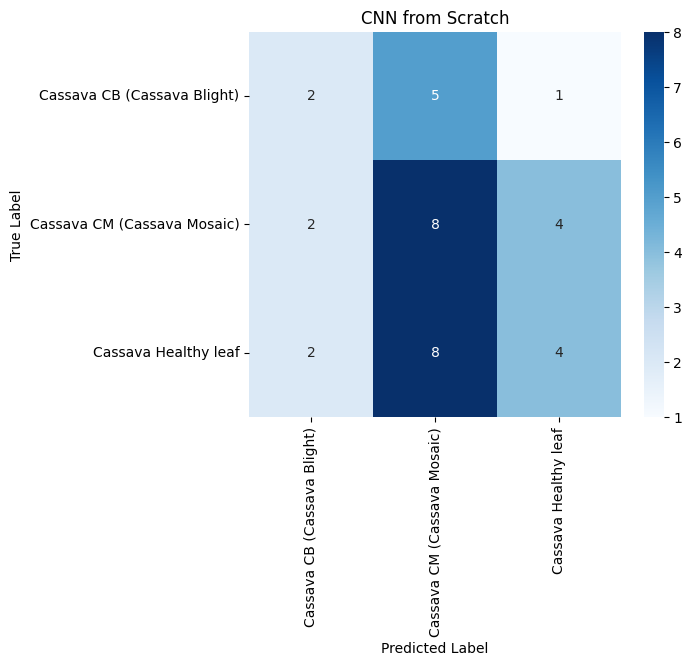

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


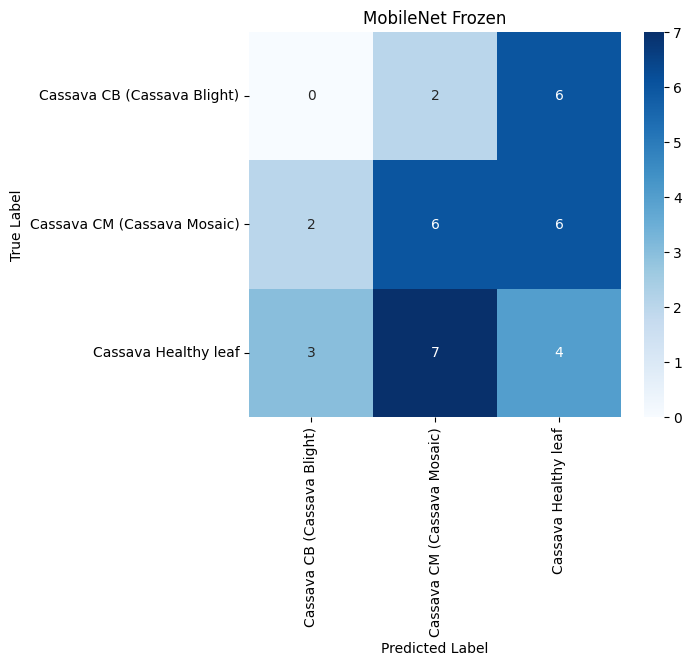

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step


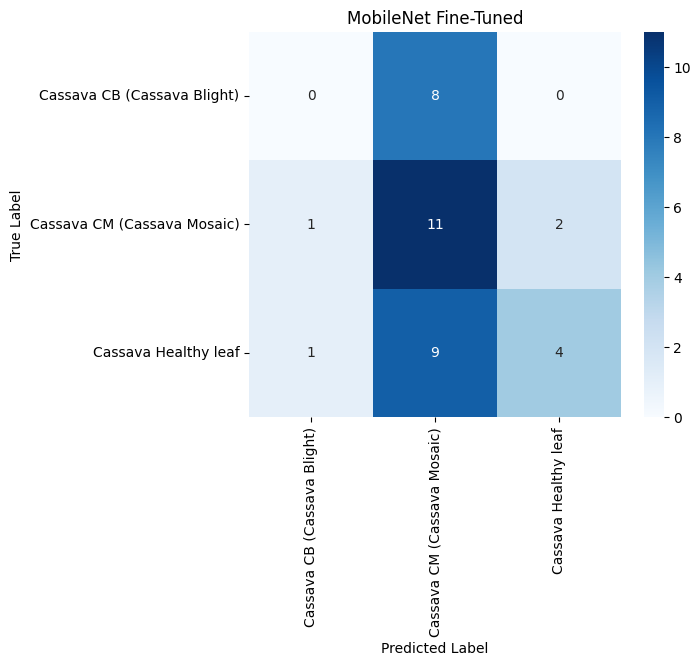

In [ ]:
#confusion matrix for the models

class_names = train_ds.class_names

plot_confusion_matrix(cnn_model, test_ds, class_names, "CNN from Scratch")
plot_confusion_matrix(model, test_ds, class_names, "MobileNet Frozen")
plot_confusion_matrix(fine_tune_model, test_ds, class_names, "MobileNet Fine-Tuned")